<a href="https://colab.research.google.com/github/umKvFL6HsSQ7hfkS/dl-final-project/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

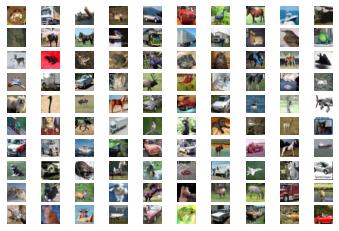

In [14]:
import matplotlib.pyplot as plt
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Input, Dense, Reshape, Flatten, LeakyReLU, Dropout, Embedding, Concatenate

#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

in_shape=(32,32,3)

In [15]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()  
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5   
                            
	return [X, trainy]

In [16]:
from keras import models
def define_discriminator(in_shape=(32,32,3), n_classes=10):

	in_label = Input(shape=(1,))  
	li = Embedding(n_classes, 50)(in_label) 
	n_nodes = in_shape[0] * in_shape[1]  
	li = Dense(n_nodes)(li)  
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
	in_image = Input(shape=in_shape) #32x32x3
	merge = Concatenate()([in_image, li]) #32x32x4 
    
	fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)  


	model = Model([in_image, in_label], out_layer)
    
	# compile model
	
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        500         ['input_9[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 1, 1024)      52224       ['embedding_4[0][0]']            
                                                                                                  
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
def define_generator(latent_dim, n_classes=10):
		
	in_label = Input(shape=(1,))  #Input of dimension 1 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
		
	n_nodes = 4 * 4  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	li = Reshape((4, 4, 1))(li)
		
		
	# image generator input
	in_lat = Input(shape=(latent_dim,))  
	n_nodes = 256 * 4 * 4
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 256))(gen) #Shape=8x8x128

	merge = Concatenate()([gen, li])  #Shape=8x8x129 

  # upsample to 8x8	
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name="transpose1")(merge) #8x8x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name="transpose2")(gen) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)

	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',  name="transpose3")(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model  

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 4096)         413696      ['input_12[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        500         ['input_11[0][0]']               
                                                                                            

In [20]:
def define_gan(g_model, d_model):
	d_model.trainable = False 
    
	gen_noise, gen_label = g_model.input  
	gen_output = g_model.output  #32x32x3
    
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [21]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_real_samples(dataset, n_samples):
	images, labels = dataset  
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1)) 
	return [X, labels], y

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1)) 
	return [images, labels_input], y

In [22]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
 
	for i in range(n_epochs):
	
		for j in range(bat_per_epo):
			
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
			y_gan = ones((n_batch, 1))

			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

	g_model.save('cifar_conditional_generator_25epochs.h5')


latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10)

2/2 [==============================] - 0s 9ms/step
Epoch>1, Batch1/390, d1=0.703, d2=0.696 g=0.691
2/2 [==============================] - 0s 9ms/step
Epoch>1, Batch2/390, d1=0.655, d2=0.699 g=0.688
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch3/390, d1=0.614, d2=0.708 g=0.680
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch4/390, d1=0.566, d2=0.729 g=0.662
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch5/390, d1=0.503, d2=0.771 g=0.637
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch6/390, d1=0.435, d2=0.831 g=0.614
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch7/390, d1=0.365, d2=0.862 g=0.630
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch8/390, d1=0.342, d2=0.826 g=0.686
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch9/390, d1=0.305, d2=0.747 g=0.774
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch10/390, d1=0.249, d2=0.714 g=0.842
2/2 [====

KeyboardInterrupt: ignored

4/4 [==============================] - 0s 9ms/step


ValueError: ignored

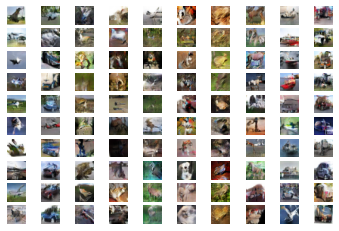

<Figure size 432x288 with 0 Axes>

In [23]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

model = load_model('cifar_conditional_generator_25epochs.h5')


latent_points, labels = generate_latent_points(100, 100)

labels = asarray([x for _ in range(10) for x in range(10)])

X  = model.predict([latent_points, labels])

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

def show_plot(examples, n):
  # for i in range(n):
  #   plt.subplot(1, 1, 1)
  #   plt.axis('off')
  #   plt.imshow(examples[i])
  #   print(i//10)
    # # print(examples.labels)
    # filename = '/content/images/%d_generated_plot_e%03d.png' % (4,i+1)
    # plt.savefig(filename)

  labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(examples[i])
  

  for i in range(n):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.imshow(examples[i])
    # print(examples.labels)
    filename = '/content/one-images/%s/_generated_plot_e%03d.png' % (labels[i%10],i//10)
    tf.keras.preprocessing.image.save_img(filename, examples[i])
    # print(filename)
    # plt.savefig(filename)
  # plt.show()
  # with open ("file.txt", "W") as output:
  #   for i in range (0,1):
  #     with open ("file.txt", "W") as output:
  #       output.write(str(X[i, :, :]))
    
show_plot(X, 100)

In [ ]:
!zip -r /content/file.zip /content/one-images
from google.colab import files
files.download("/content/file.zip")